In [1]:
import cupy as cp
import numpy as np
import pandas as pd
import time
import cudf as cf
import cuml as ml
import rmm

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
import rstl

from time import perf_counter

/home/fei/svo0175/miniconda3/lib/python3.7/site-packages/treelite/gallery/__init__.py:7: FutureWarning: treelite.gallery.sklearn has been moved to treelite.sklearn. treelite.gallery.sklearn will be removed in version 1.1.
  FutureWarning)
/home/fei/svo0175/miniconda3/lib/python3.7/site-packages/treelite/gallery/sklearn/__init__.py:9: FutureWarning: treelite.gallery.sklearn has been moved to treelite.sklearn. treelite.gallery.sklearn will be removed in version 1.1.
  FutureWarning)


In [2]:
from cuml.ensemble import RandomForestRegressor
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
import matplotlib.pyplot as plt

In [4]:
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

In [5]:
def cuda_test_batch():
    print(cp.__version__)
    print(cf.__version__)
    print(ml.__version__)

    s = time.time()
    x_cpu = np.ones((1000,1000,1000))
    e = time.time()
    print(e - s)

    s = time.time()
    x_gpu = cp.ones((1000,1000,1000))
    cp.cuda.Stream.null.synchronize()
    e = time.time()
    print(e - s)
    
    ### Numpy and CPU
    s = time.time()
    x_cpu *= 5
    x_cpu *= x_cpu
    x_cpu += x_cpu
    e = time.time()
    print(e - s)

    ### CuPy and GPU
    s = time.time()
    x_gpu *= 5
    x_gpu *= x_gpu
    x_gpu += x_gpu
    cp.cuda.Stream.null.synchronize()
    e = time.time()
    print(e - s)


In [6]:
def lowess_cp_inline(x, y, f=2. / 3., it=3, dl = 1.0):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = x.shape[0]
    r = cp.int(cp.ceil(f * n))
    h = cp.zeros(n)
    for i in range(n):
        h[i] = cp.sort(cp.abs(x - x[i]))[r]
    yest = cp.zeros(n)
    delta = cp.repeat(cp.array(dl), n)
    for iteration in range(it):
        for i in range(n):
            row = i
            weights = delta * cp.power(1 - cp.power(cp.clip(cp.abs((x[row, None] - x[None, :])/h[row]), 0.0, 1.0), 3.0), 3.0)
            b = cp.array(cp.array([cp.sum(weights * y), cp.sum(weights * y * x)]))
            A = cp.array(cp.array([cp.array([cp.sum(weights), cp.sum(weights * x)]), cp.array([cp.sum(weights * x), cp.sum(weights * x * x)])]))
            beta = cp.linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = cp.float32(cf.Series(cp.abs(residuals)).median())
        delta = cp.clip(residuals / (6.0 * s), -1, 1)
        delta = cp.power((1 - cp.power(delta, 2.0)), 2)
    return yest

In [7]:
def fill_seasonal(month, day, hour, seasonal_dict):
    season = seasonal_dict[month]
    return season[(season.Day_of_week == day) & (season.Hour == hour)].Seasonal.values[0]

In [8]:
def IsSummer_func(x, out):
    for i, a in enumerate(x):
        if a >= 6 and a <= 8:
            out[i] = 1
        else:
            out[i] = 0

In [9]:
def heatint_season_func(x, y, out):
    for i, (a, e) in enumerate(zip(x, y)):
        if a < 13 and e == 1:
            out[i] = 1
        else:
            out[i] = 0

In [10]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: cp.array, y_pred: cp.array) -> cp.float32:
    return cp.mean(cp.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: cp.array, y_pred: cp.array) -> cp.float32:
    return cp.mean(cp.abs((y_pred - y_true) / ((cp.abs(y_true) + cp.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: cf.DataFrame) -> cf.Series:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: cf.Series, y_pred: cf.Series) -> cf.Series:
    mae, mse, mape, smape = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    return cf.Series(cp.array([mae, mse, mape, smape]), index=['MAE', 'MSE', 'MAPE', 'SMAPE'])
#     return cf.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape}], index=[0])

In [14]:
n_diff=1
start_data = perf_counter()
df = cf.read_csv('data/ppnet_metar_v7.csv',  sep=';', index_col=0)
# TODO: Odkomentovat pro repeat datasetu 10x
# df = cf.concat([df]*10, ignore_index=True)
start = perf_counter()
start_full = perf_counter()

df = df[df.Year < 2019]
df['TestSet'] = 0
df.loc[df.Year == 2018, 'TestSet'] = 1
X, y = df.drop('Consumption', axis=1), df.Consumption

y_diff = y.diff(n_diff).dropna()
y_diff_index = y_diff.index
X['Consumption_diff_1'] = y_diff
lags = cp.array([24, 25, 35, 36, 37, 47, 48, 49, 71,72,73, 95, 96, 97, 119, 120, 121, 143,144,145, 168, 167, 169])
lags_arr = cp.arange(n_diff, 24)
lags_con = cp.concatenate((lags, lags_arr))
lags = lags_con

for x in lags:
    X[f'Consumption_lag_{x}'] = y.shift(x)
    X[f'Temperature_lag_{x}'] = X['Temperature'].shift(x)
    X[f'Consumption_diff_1_lag_{x}'] = X['Consumption_diff_1'].shift(x)
    X[f'Humidity_lag_{x}'] = X['Humidity'].shift(x)
    X[f'Cena_lag_{x}'] = X['Cena_bfill'].shift(x)
    X[f'Windspeed_lag_{x}'] = X['Wind_speed'].shift(x)
    X[f'Pressure_lag_{x}'] = X['Pressure'].shift(x)

X['Day_of_week_sin'] = cp.sin(2 * cp.pi * X['Day_of_week']/7.0)
X['Day_of_week_cos'] = cp.cos(2 * cp.pi * X['Day_of_week']/7.0)
X['Month_sin'] = cp.sin(2 * cp.pi * X['Month']/12.0)
X['Month_cos'] = cp.cos(2 * cp.pi * X['Month']/12.0)
X['Hour_sin'] = cp.sin(2 * cp.pi * X['Hour']/23.0)
X['Hour_cos'] = cp.cos(2 * cp.pi * X['Hour']/23.0)
X['Day_sin'] = cp.sin(2 * cp.pi * X['Day']/31.0)
X['Day_cos'] = cp.cos(2 * cp.pi * X['Day']/31.0)

cp.cuda.Stream.null.synchronize()
end = perf_counter()
print(f'Time before STL: {end - start}')
start = perf_counter()

x = cp.array([i for i in range(len(y_diff.values))])
f = 0.01
period = 24*7
trend = lowess_cp_inline(x, y_diff.values, f, it=1, dl=0.01)
detrended = y_diff.values - trend
period_averages = cp.array([cp.mean(detrended[i::period]) for i in range(period)])
period_averages -= cp.mean(period_averages)
seasonal = cp.tile(period_averages, len(y_diff.values) // period + 1)[:len(y_diff.values)]
resid = detrended - seasonal
residual_trend = resid + trend

X['Seasonal'] = cp.concatenate([cp.array([cp.nan]*n_diff), seasonal])
X['Residual'] = cp.concatenate([cp.array([cp.nan]*n_diff), residual_trend])
X['Trend'] = cp.concatenate([cp.array([cp.nan]*n_diff), trend])

cp.cuda.Stream.null.synchronize()
end = perf_counter()
print(f'Time computing STL: {end - start}')
start = perf_counter()

for x in lags:
    X[f'Seasonal_lag_{x}'] = X['Seasonal'].shift(x)
    X[f'Residual_lag_{x}'] = X['Residual'].shift(x)
    X[f'Residual_lag_inverse_{x}'] = X['Residual'].shift(x)*-1

X['IsSummer'] = 0
IsSummer_final = X.apply_rows(IsSummer_func, incols={'Month':'x'}, outcols={'out': cp.int}, kwargs={}).out
X['IsMiddleOfTheDay'] = 0
X.loc[X.Hour.applymap(lambda x: x >= 13 and x <= 15), 'IsMiddleOfTheDay'] = 1 
X['IsHeatingSeason'] = 1
X.loc[X.Month.applymap(lambda x: x >= 6 and x <= 8), 'IsHeatingSeason'] = 0
heat_final = X.apply_rows(heatint_season_func, incols={'Temperature':'x', 'IsHeatingSeason':'y'}, outcols={'out': cp.int}, kwargs={}).out
X['IsHeatingSeason'] = heat_final
X['IsWeekend'] = 0
X.loc[X.Day_of_week.applymap(lambda x: x >= 6 and x <= 7), 'IsWeekend'] = 1
X['IsStartOfGasTradeDay'] = 0
X.loc[X.Hour == 6, 'IsStartOfGasTradeDay'] = 1

y = X.Residual
X_train, X_test, y_train, y_test = X[X.TestSet == 0], X[X.TestSet == 1], y[X.TestSet == 0], y[X.TestSet == 1]

arr_drop_columns = cf.Series(['Cena',
 'Cena_bfill',
 'Clouds_high_m',
 'Clouds_high_text',
 'Clouds_low_m',
 'Clouds_low_text',
 'Clouds_medium_m',
 'Clouds_medium_text',
 'Consumption_diff_1',
 'Datetime.1',
 'Dewpoint',
 'Humidity',
 'IsMissing',
 'Mnozstvi',
 'Mnozstvi_bfill',
 'Phenomena',
 'Pressure',
 'Pressure2',
 'PreviousTemp_lag24',
 'PreviousTemp_lag48',
 'Recent_phenomena',
 'Residual',
 'Temperature',
 'TestSet',
 'Trend',
 'Visibility',
 'Wind_direction',
 'Wind_speed',
 'Year'])

X_train_selected_features = X_train.drop(arr_drop_columns, axis=1)
X_test_selected_features = X_test.drop(arr_drop_columns, axis=1)
X_train_selected_features_nona = X_train_selected_features.dropna()
X_test_selected_features_nona = X_test_selected_features.dropna()
y_train_no_na = y_train.dropna()
y_test_no_na = y_test.dropna()
y_train_no_na = y_train_no_na[y_train_no_na.index.isin(X_train_selected_features_nona.index)]
X_test_selected_features_nona = X_test_selected_features_nona[X_test_selected_features_nona.index.isin(y_test_no_na.index)]

cp.cuda.Stream.null.synchronize()
end = perf_counter()
print(f'Time second phase preprocess: {end - start}')

cp.cuda.Stream.null.synchronize()
end_full = perf_counter()
print(f'Full pipeline: {end_full - start_full}')
print(f'Full pipeline (with data load): {end_full - start_data}')

Time before STL: 0.7480390593409538
Time computing STL: 158.44393079727888
Time second phase preprocess: 1.4179246500134468
Full pipeline: 160.61122177541256
Full pipeline (with data load): 160.65943113714457


In [15]:
start = perf_counter()
X_train_selected_features_nona = X_train_selected_features_nona.astype(cp.float32)
y_train_no_na = y_train_no_na.astype(cp.float32)
X_test_selected_features_nona = X_test_selected_features_nona.astype(cp.float32)
y_test_no_na = y_test_no_na.astype(cp.float32)
alg = RandomForestRegressor(n_estimators=5, accuracy_metric='mse', max_features=1.0, seed=14)
alg.fit(X_train_selected_features_nona, y_train_no_na)
y_pred = alg.predict(X_test_selected_features_nona)
ps_y_pred = y_pred
ps_y_pred.index = y_test_no_na.index
y_pred_tmp = ps_y_pred + X[X.TestSet == 1].Seasonal
df_tmp = (df.Consumption.shift(n_diff)[df.TestSet == 1] + y_pred_tmp)
orig_data = df.loc[df.TestSet == 1, 'Consumption']
df_res_hourly = cf.DataFrame({'y_true': orig_data, 'y_pred': df_tmp})
cp.cuda.Stream.null.synchronize()
end = perf_counter()
print(f'Time for ML phase: {end - start}')

/home/fei/svo0175/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Setting the random seed does not fully guarantee the exact same results at this time.
  


Time for ML phase: 5.902379095554352


In [16]:
compute_metrics(df_res_hourly)

MAE      2.558485e+03
MSE      1.706865e+07
MAPE     3.398827e+00
SMAPE    3.310298e+00
dtype: float64

In [11]:
trend = lowess_cp_inline(x, y_diff.values, f, it=1, dl=0.01)

In [12]:
trend[:10]

array([-4252.82214212, -4200.76424686, -4148.76340327, -4096.82015725,
       -4044.93503335, -3993.10853604, -3941.34116593, -3889.63344665,
       -3837.98595566, -3786.39934209])

In [13]:
detrended = y_diff.values - trend

In [14]:
period = 24*7

In [18]:
period_averages = cp.array([cp.mean(detrended[i::period]) for i in range(period)])

In [19]:
period_averages -= cp.mean(period_averages)

In [23]:
seasonal = cp.tile(period_averages, len(y_diff.values) // period + 1)[:len(y_diff.values)]

In [25]:
resid = detrended - seasonal

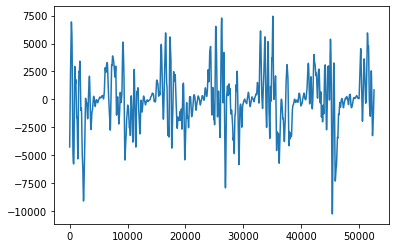

In [33]:
plt.plot(cp.asnumpy(x), cp.asnumpy(trend))

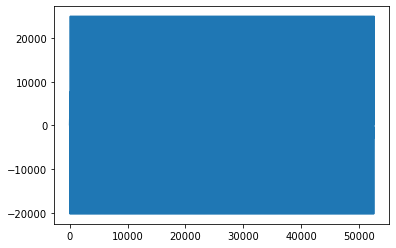

In [34]:
plt.plot(cp.asnumpy(x), cp.asnumpy(seasonal))

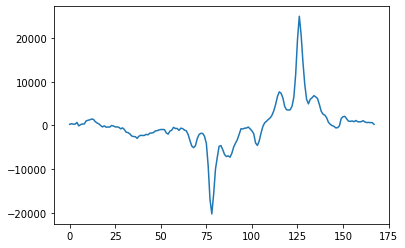

In [39]:
plt.plot(cp.asnumpy(x[:168]), cp.asnumpy(seasonal[:168]))

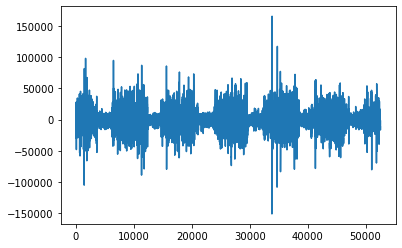

In [35]:
plt.plot(cp.asnumpy(x), cp.asnumpy(resid))

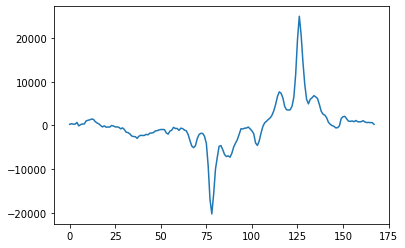

In [37]:
plt.plot(cp.asnumpy(period_averages))

In [6]:
pd.Series(cp.asnumpy(y_diff.values))

0        -6108.0
1       -11776.0
2       -14400.0
3       -14668.0
4        -7944.0
          ...   
52555    -8593.0
52556   -11178.0
52557   -12489.0
52558   -15179.0
52559   -10751.0
Length: 52560, dtype: float64

In [10]:
start_rstl = perf_counter()
y_diff_np = cp.asnumpy(y_diff.values)[:100]
stl_decomp = rstl.STL(y_diff_np, freq=7, robust=False, s_window='periodic')
end_rstl = perf_counter()
print(end_rstl - start_rstl)

0.0512222945690155


In [11]:
stl_decomp.trend

array([-17459.60046692, -13469.53055977,  -9479.46065262,  -5250.27819633,
        -1021.09574004,   4135.6341368 ,   9292.36401363,  12715.00101151,
        16137.63800939,  15219.53161184,  14301.42521428,  10821.78362204,
         7342.1420298 ,   4424.30569335,   1506.4693569 ,    820.53108988,
          134.59282285,    267.5818156 ,    400.57080835,    796.92623854,
         1193.28166872,   1596.6975249 ,   2000.11338108,   2887.2339667 ,
         3774.35455232,   4795.46713253,   5816.57971275,   6190.75392982,
         6564.9281469 ,   6135.95812943,   5706.98811195,   5528.53531329,
         5350.08251462,   6823.7573431 ,   8297.43217158,   9726.04183233,
        11154.65149308,  10563.03958227,   9971.42767147,   6534.020426  ,
         3096.61318054,    146.64633623,  -2803.32050808,  -4615.96443356,
        -6428.60835903,  -7601.4750805 ,  -8774.34180196, -10420.47206324,
       -12066.60232453, -14258.90838406, -16451.21444359, -18094.39510838,
       -19737.57577317, -

In [36]:
trend, seasonal, residual, weights = cp.array(stl_decomp.trend), cp.array(stl_decomp.seasonal), cp.array(stl_decomp.remainder), cp.array(stl_decomp.weights)

In [19]:
residual_trend = residual + trend

In [20]:
X.shape

(52584, 203)

In [21]:
y.shape

(52584,)

In [30]:
X[f'Seasonal'] = cf.Series((cp.concatenate([cp.array([cp.nan]*n_diff), seasonal])), index=X.index)
X[f'Residual'] = cf.Series((cp.concatenate([cp.array([cp.nan]*n_diff), residual_trend])), index=X.index)
X[f'Trend'] = cf.Series((cp.concatenate([cp.array([cp.nan]*n_diff),trend])), index=X.index)

Difference RSTL: 237.84162295609713
